# This file: Summ stats / descriptives
# Dependencies: agg_enrollment_CDS, agg_enrollment_CD, predicted_flows80, predicted_flows90
# Outputs: 
# Last updated: 2/21/2019

In [1]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/tsengtammy/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [63]:
districts = pd.read_csv('/Users/tsengtammy/Dropbox/3 TT/4. Thesis/build/data/output/agg_enrollment_CD.csv')
schools = pd.read_csv('/Users/tsengtammy/Dropbox/3 TT/4. Thesis/build/data/output/agg_enrollment_CDS.csv')

In [9]:
predicted80 = pd.read_csv('/Users/tsengtammy/Dropbox/3 TT/4. Thesis/build/data/output/predicted_flows80.csv')
predicted90 = pd.read_csv('/Users/tsengtammy/Dropbox/3 TT/4. Thesis/build/data/output/predicted_flows90.csv')

# Basic time series

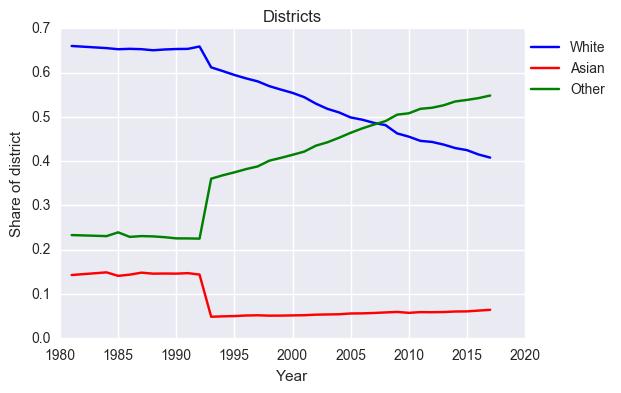

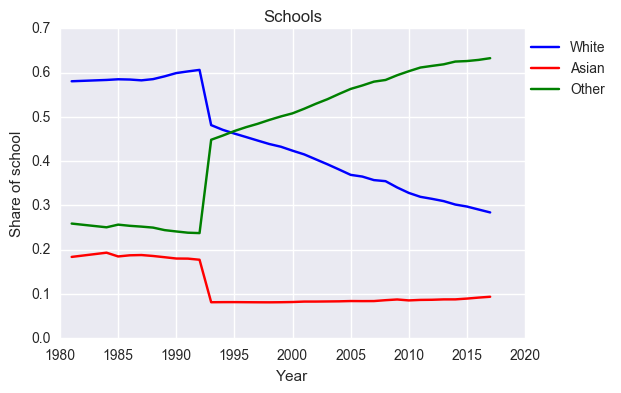

In [126]:
dfs = [districts, schools]

for i in range(len(dfs)):
    
    if i==0:
        string = 'district'
    else:
        string = 'school'

    # aggregate data
    grouped = dfs[i].groupby('YEAR').mean().reset_index()
    
    # plot
    f, ax = plt.subplots()
    ax.plot(grouped['YEAR'].apply(lambda x: int(x)), grouped['White_share'], color='blue', label='White', linestyle='-')
    ax.plot(grouped['YEAR'].apply(lambda x: int(x)), grouped['Asian_share'], color='red', label='Asian', linestyle='-')
    ax.plot(grouped['YEAR'].apply(lambda x: int(x)), grouped['Other_share'], color='green', label='Other', linestyle='-')
    plt.ylabel('Share of {}'.format(string))
    plt.xlabel('Year')
    plt.title('{}s'.format(string.title()))
    ax.legend(bbox_to_anchor=(1.2,1))
    #plt.show()
    
    f.savefig('/Users/tsengtammy/Dropbox/3 TT/4. Thesis/analysis/output/{}_share_by_years_81.png'.format(string))

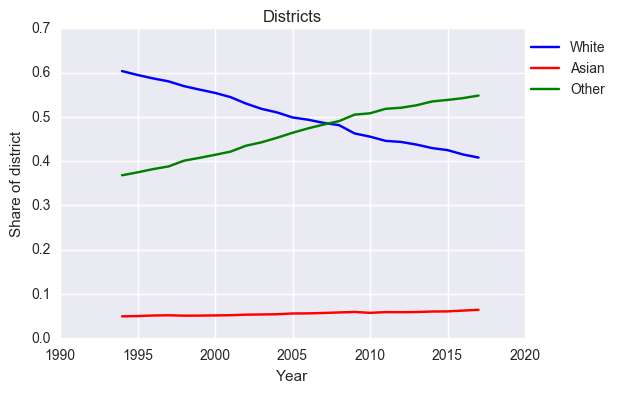

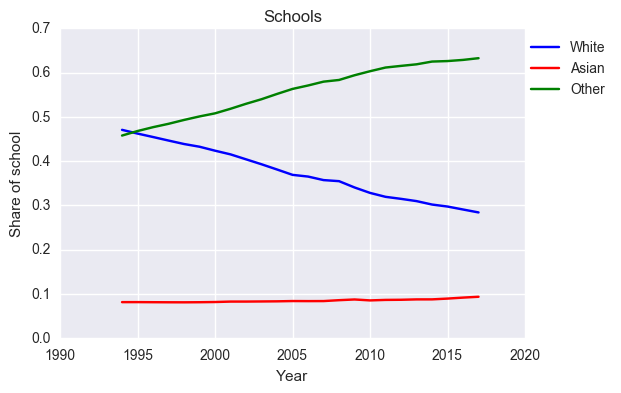

In [128]:
# Only 1994 data onward

dfs = [districts, schools]

for i in range(len(dfs)):
    
    if i==0:
        string = 'district'
    else:
        string = 'school'

    # aggregate data
    grouped = dfs[i].groupby('YEAR').mean().reset_index()
    grouped = grouped[grouped['YEAR']>=1994]
    
    # plot
    f, ax = plt.subplots()
    ax.plot(grouped['YEAR'].apply(lambda x: int(x)), grouped['White_share'], color='blue', label='White', linestyle='-')
    ax.plot(grouped['YEAR'].apply(lambda x: int(x)), grouped['Asian_share'], color='red', label='Asian', linestyle='-')
    ax.plot(grouped['YEAR'].apply(lambda x: int(x)), grouped['Other_share'], color='green', label='Other', linestyle='-')
    plt.ylabel('Share of {}'.format(string))
    plt.xlabel('Year')
    plt.title('{}s'.format(string.title()))
    ax.legend(bbox_to_anchor=(1.2,1))
    plt.show()

    f.savefig('/Users/tsengtammy/Dropbox/3 TT/4. Thesis/analysis/output/{}_share_by_years_94.png'.format(string))

# Distribution of Asian_share by year

Long right tail of high-Asian-share school districts

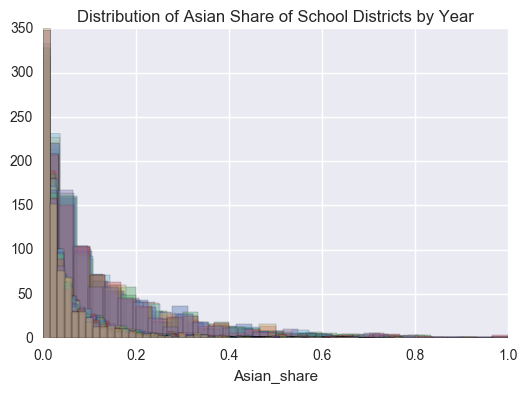

In [74]:
f, ax = plt.subplots()
for year in districts['YEAR'].unique():
    subset = districts[districts['YEAR']==year]
    sns.distplot(subset['Asian_share'].dropna(), kde=False, label=str(year))

plt.title('Distribution of Asian Share of School Districts by Year')
f.savefig('/Users/tsengtammy/Dropbox/3 TT/4. Thesis/analysis/output/asian_share_dist.png')

follow up: what is the year that has less of a tail?

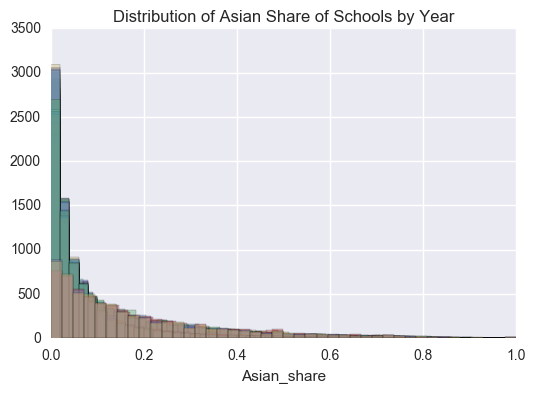

In [71]:
f, ax = plt.subplots()
for year in schools['YEAR'].unique():
    subset = schools[schools['YEAR']==year]
    sns.distplot(subset['Asian_share'].dropna(), kde=False, label=str(year))

plt.title('Distribution of Asian Share of Schools by Year')
f.savefig('/Users/tsengtammy/Dropbox/3 TT/4. Thesis/analysis/output/asian_share_schools.png')

# First stage instruments

                            OLS Regression Results                            
Dep. Variable:           Asian_inflow   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.212e+04
Date:                Fri, 22 Feb 2019   Prob (F-statistic):           8.21e-52
Time:                        15:44:20   Log-Likelihood:                -385.85
No. Observations:                  37   AIC:                             773.7
Df Residuals:                      36   BIC:                             775.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
hat_Asian_t-(t-1)     3.1852      0.02

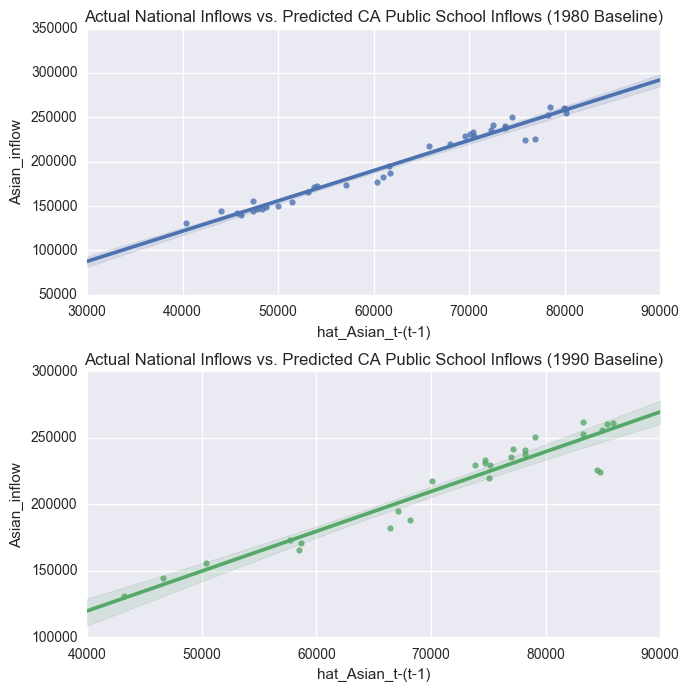

In [120]:
f, ax = plt.subplots(2, 1, figsize=(7,7))
dfs = [predicted80, predicted90]

for i in range(len(dfs)):
    
    df = dfs[i]
    year = 1980 + 10 * i
    
    # These are the actual national flows
    act_flows = df[['Year'] + [x for x in df.columns.values if x.endswith('_inflow')]].drop_duplicates()
    act_flows['Asian_inflow'] = act_flows.drop('Year', axis=1).sum(axis=1)

    # These are the sum of predicted flows for CA 
    pred_flows = df[['Year', 'hat_Asian_t-(t-1)']].groupby('Year').sum().reset_index()
    
    # Plot
    sns.regplot(pred_flows['hat_Asian_t-(t-1)'], act_flows['Asian_inflow'], ax=ax[i])
    ax[i].set_title('Actual National Inflows vs. Predicted CA Public School Inflows ({} Baseline)'.format(year))
    
    # Get reg line
    mod = sm.OLS(act_flows['Asian_inflow'], pred_flows['hat_Asian_t-(t-1)'])
    res = mod.fit()
    print(res.summary())
    
f.tight_layout()
f.savefig('/Users/tsengtammy/Dropbox/3 TT/4. Thesis/analysis/output/actual_vs_pred_flows.png')

Instrument types:
- Assign actual migrants
- Assign predicted migrants, 1980-2017
- Assign predicted migrants, 1990-2017
- Predict with 1980 baseline, 1990-2017

To regress first stage:
- Actual Asian enrollment in school district
- Actual Asian share of enrollment inflow in school district (Peri and Sparber RHS)

In [96]:
iv_80 = pd.read_csv('/Users/tsengtammy/Dropbox/3 TT/4. Thesis/build/data/output/enrollment_IV_SD.csv')
iv_90 = pd.read_csv('/Users/tsengtammy/Dropbox/3 TT/4. Thesis/build/data/output/enrollment_IV_SD_90base.csv')

# 80 on 80 onward

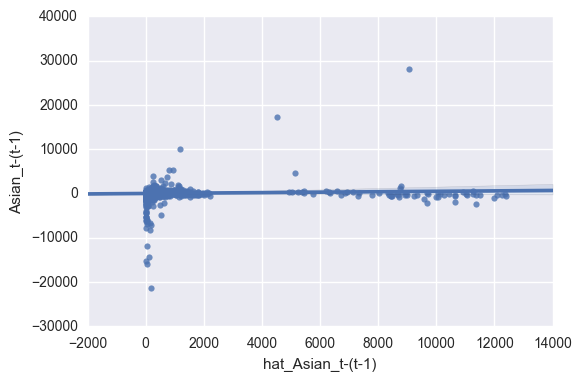

In [108]:
# P&S specification without shares?
sns.regplot(iv_80['hat_Asian_t-(t-1)'], iv_80['Asian_t-(t-1)'])

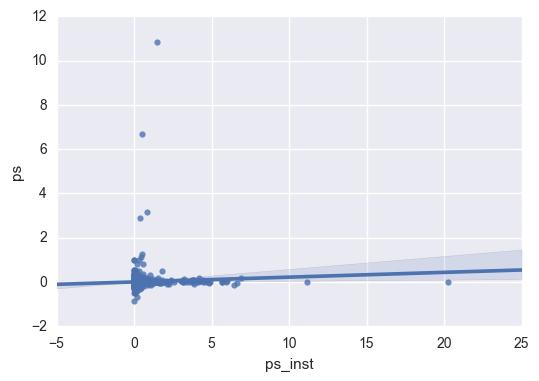

In [107]:
# P&S specification
iv_80['ps'] = iv_80['Asian_t-(t-1)'] / iv_80['Total_(t-1)']
iv_80['ps_inst'] = iv_80['hat_Asian_t-(t-1)'] / iv_80['Total_(t-1)']
sns.regplot(iv_80['ps_inst'], iv_80['ps'])

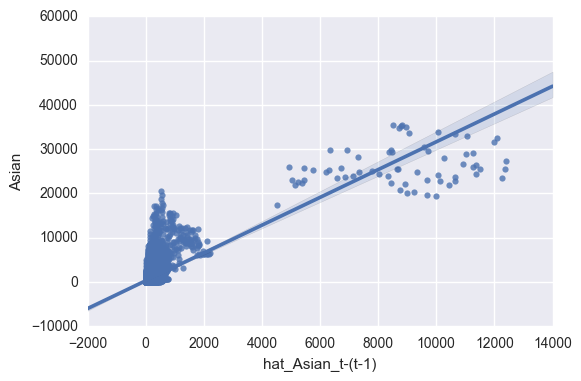

In [98]:
# Boustan specification
sns.regplot(iv_80['hat_Asian_t-(t-1)'], iv_80['Asian'])

# 90 on 90 onward

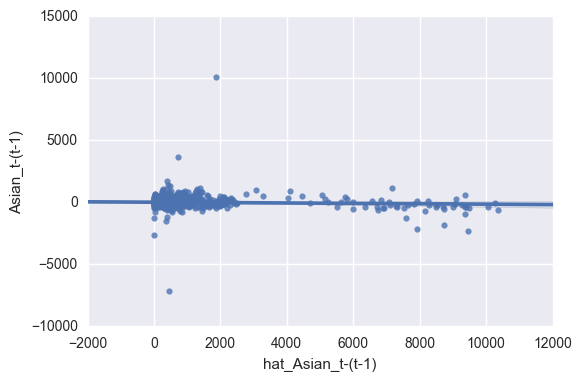

In [109]:
# P&S specification without shares?
sns.regplot(iv_90['hat_Asian_t-(t-1)'], iv_90['Asian_t-(t-1)'])

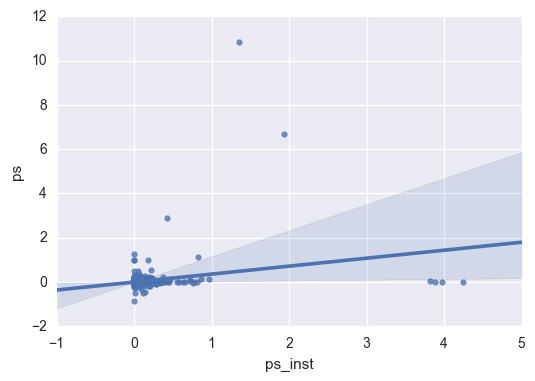

In [110]:
# P&S specification
iv_90['ps'] = iv_90['Asian_t-(t-1)'] / iv_90['Total_(t-1)']
iv_90['ps_inst'] = iv_90['hat_Asian_t-(t-1)'] / iv_90['Total_(t-1)']
sns.regplot(iv_90['ps_inst'], iv_90['ps'])

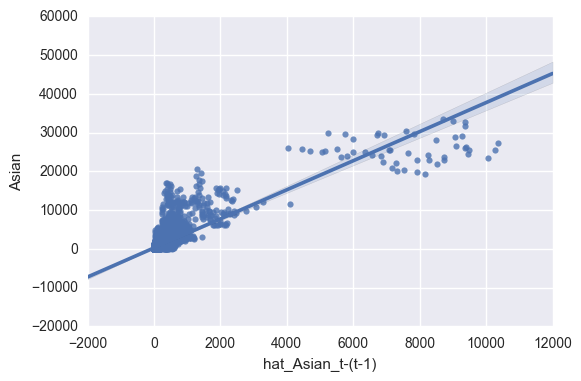

In [111]:
# Boustan specification
sns.regplot(iv_90['hat_Asian_t-(t-1)'], iv_90['Asian'])

# 80 on 90 onward

In [114]:
iv_8090 = iv_80[iv_80['YEAR']>=1990].copy()

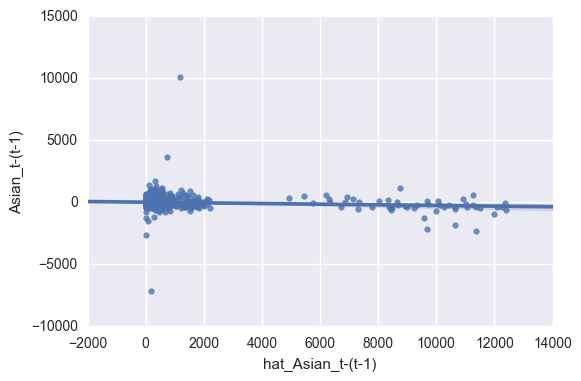

In [115]:
# P&S specification without shares?
sns.regplot(iv_8090['hat_Asian_t-(t-1)'], iv_8090['Asian_t-(t-1)'])

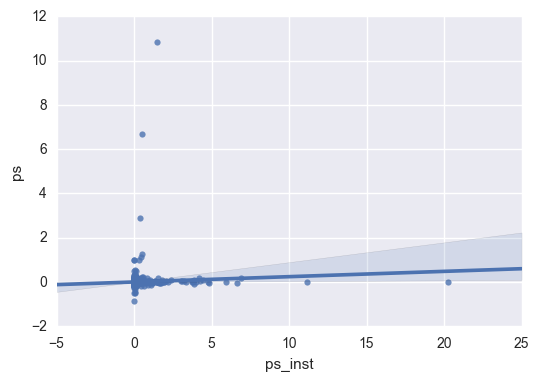

In [116]:
# P&S specification
iv_8090['ps'] = iv_8090['Asian_t-(t-1)'] / iv_8090['Total_(t-1)']
iv_8090['ps_inst'] = iv_8090['hat_Asian_t-(t-1)'] / iv_8090['Total_(t-1)']
sns.regplot(iv_8090['ps_inst'], iv_8090['ps'])

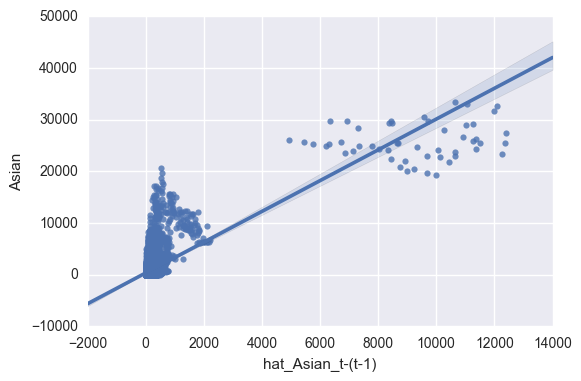

In [117]:
# Boustan specification
sns.regplot(iv_8090['hat_Asian_t-(t-1)'], iv_8090['Asian'])

In [118]:
iv_80.columns

Index(['CD Code', 'YEAR', 'American Indian or Alaska', 'Asian',
       'Black, not Hispanic', 'Filipino', 'Hispanic or Latino',
       'Pacific Islander', 'White', 'Total', 'L', 'White_share', 'Asian_share',
       'Other_share', 'American Indian or Alaska_t-(t-1)', 'Asian_t-(t-1)',
       'Black, not Hispanic_t-(t-1)', 'Filipino_t-(t-1)',
       'Hispanic or Latino_t-(t-1)', 'Pacific Islander_t-(t-1)',
       'White_t-(t-1)', 'Total_t-(t-1)', 'L_t-(t-1)', 'White_share_t-(t-1)',
       'Asian_share_t-(t-1)', 'Other_share_t-(t-1)', 'County',
       'County_Population', 'District', 'DOC', 'DOCType',
       'American Indian or Alaska_(t-1)', 'Asian_(t-1)',
       'Black, not Hispanic_(t-1)', 'Filipino_(t-1)',
       'Hispanic or Latino_(t-1)', 'Pacific Islander_(t-1)', 'White_(t-1)',
       'Total_(t-1)', 'L_(t-1)', 'White_share_(t-1)', 'Asian_share_(t-1)',
       'Other_share_(t-1)', 'County_Population_(t-1)', 'NAME',
       'hat_Asian Indian_t-(t-1)', 'hat_Chinese_t-(t-1)',
       'hat_